In [32]:
# train_test_split
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import catboost
from sklearn.decomposition import PCA


In [25]:
# not using image data for now
# there are total of 1451 rows in dataset, I have removed 49 rows for which image was not downloadable
df = pd.read_csv('../data/processed/cleaned_results_1.csv')
X = df[['name','brandName','imageId']]
Y = df['categoryName']

# Cannot use Statrify here since there are categories with only 1 value, so it's not possible to split them
X_train,X_test, y_train,y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [31]:
X_train.head()

,name,brandName,imageId
1287,Serge Lutens La Fille De Berlin Eau De Parfum ...,Serge Lutens,1333
1035,Fanola Oro Puro Therapy Color Keratin 100ml - ...,Fanola,1068
416,Virgin Island Water by Creed Eau De Parfum 50ml,Creed,430
1166,Redken Color Extend Magnetics Conditioner for ...,Redken,1210
86,L'OCCITANE Cade Energizing Fluid 50ml Fresh Fa...,L'Occitane,91


In [26]:
X_train.loc[374]


name         L'Oreal Paris Waterproof Eye Makeup 125ml
brandName                                L'Oréal Paris
imageId                                            388
Name: 374, dtype: object

### no pre-processing but with image data

In [30]:
import os
import pandas as pd
import numpy as np
from PIL import Image

# PyTorch imports for image processing
import torch
import torchvision.models as models
import torchvision.transforms as transforms

# CatBoost and Pool
from catboost import CatBoostClassifier, Pool

# 1. Extracting Image Embeddings using a pre-trained CNN (ResNet50)

# Set PyTorch device: Use GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transforms – these must match what the pre-trained network expects.
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),   # ResNet50 expects 224x224 inputs
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the pre-trained ResNet50 model and remove the final classification layer.
model_resnet = models.resnet50(weights=True)

# this is removing the classification layer to further use transfer learning
model_resnet.fc = torch.nn.Identity()  

model_resnet = model_resnet.to(device)

model_resnet.eval()  # Set model to evaluation mode

def extract_embedding(image_path, model, transform, device):
    """
    Given the path to an image, returns the embedding vector using the provided model.
    """
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
       print(e)

    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        embedding = model(image_tensor)
    # Return a flattened numpy array (e.g., dimension 2048 for ResNet50)
    return embedding.cpu().numpy().flatten()


image_folder = '../data/processed/images'  

def get_image_path(image_index):
    # This helper constructs the file path for the image corresponding to a row.
    return os.path.join(image_folder, f'{image_index}.jpg')

# Looping  X_train to extract the embedding for each image.
embeddings = []
for idx, row in X_train.iterrows():
    img_path = get_image_path(row['imageId'])
    emb = extract_embedding(img_path, model_resnet, transform, device)
    if emb is None:
        # In case of error, you can fill with zeros or NaNs
        emb = np.zeros(2048)   # ResNet50 produces a 2048-dim embedding.
    embeddings.append(emb)

# Convert the list of embeddings to a numpy array.
embedding_array = np.array(embeddings)




/home/kamesh/interview-tests/qogita/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
# apply PCA to reduce the dimensionality of the embeddings
pca = PCA(n_components=100)
reduced_embeddings = pca.fit_transform(embedding_array)

In [37]:
reduced_embeddings.shape
# Create a DataFrame for these embeddings, naming each column.
emb_columns = [f'img_feat_{i}' for i in range(reduced_embeddings.shape[1])]
embedding_df = pd.DataFrame(reduced_embeddings, columns=emb_columns)

In [38]:
embedding_df

,img_feat_0,img_feat_1,img_feat_2,img_feat_3,img_feat_4,img_feat_5,img_feat_6,img_feat_7,img_feat_8,img_feat_9,...,img_feat_90,img_feat_91,img_feat_92,img_feat_93,img_feat_94,img_feat_95,img_feat_96,img_feat_97,img_feat_98,img_feat_99
0,2.892944,-6.914602,-0.794337,5.560281,3.144362,6.198479,-0.829874,4.209391,3.622006,-0.193153,...,-0.370734,-0.628683,-0.234850,-0.491407,0.780808,0.206282,-0.197779,0.839848,-0.701659,0.338454
1,3.214324,2.638633,-0.347341,7.978452,2.344690,-1.280431,-5.085562,-2.861019,2.271288,0.306808,...,-0.727556,-0.277197,-0.464948,-0.503546,-0.054972,0.300541,0.189451,-0.174098,-0.199202,-0.589344
2,9.433667,-6.502858,-6.343246,3.824913,-0.007802,-0.560779,0.046176,-3.667025,3.379453,0.554489,...,-0.836690,0.455163,-0.085892,-0.143504,0.634771,-0.768633,-0.262103,0.560896,-0.374220,0.015768
3,5.543778,5.761894,1.357753,-3.005255,-0.241280,4.257364,-0.193756,-3.332898,-0.345827,-0.150668,...,-0.334874,1.110550,0.378220,-0.175053,-0.378870,-0.324319,-0.007714,1.011498,0.722269,0.048596
4,2.108592,4.834786,-0.983147,-6.885558,-3.279818,0.650756,-2.367115,-1.016352,-2.442203,-1.024693,...,0.828022,-0.312422,-1.027130,0.448004,-0.166398,-0.158279,-0.368289,-0.476536,0.309004,-0.259189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,-4.025115,-5.172726,8.744329,4.538276,-1.807911,-4.004988,-0.998472,1.654848,-0.068212,2.046849,...,-0.382076,0.029875,0.431915,-0.070909,-0.164066,0.399940,-0.034491,0.321315,-0.204379,-1.213428
1156,-0.590171,6.232531,0.401405,-0.321170,-0.402345,1.397388,4.069142,4.647809,-0.965210,-0.990140,...,0.411927,-0.233156,0.615360,0.196148,-0.175274,-0.341103,-0.060294,-0.050669,0.693429,-0.278623
1157,-1.232661,-2.079960,0.559901,11.518756,4.561714,3.342127,1.715968,-3.095663,-3.798072,0.056998,...,-0.305022,-1.370399,-0.796381,0.432416,0.636849,0.254057,-0.024274,-0.351935,-0.427521,0.316662
1158,0.542136,1.280232,-4.235166,-6.166921,0.056846,-2.993592,-2.866371,-2.622151,2.497605,0.381759,...,0.283253,0.435665,-0.470313,-0.260016,-0.557534,-0.170912,0.982875,0.286352,0.346522,-0.390646


In [42]:
# Merge the image embeddings with your original data (drop imageUrl if not needed).
final_train_df = pd.concat([X_train.reset_index(drop=True), embedding_df], axis=1)

In [ ]:
# dropping ImageId since we don't need it anymore
final_train_df.drop(columns=['imageId'], inplace=True)

In [49]:
final_train_df.columns

Index(['name', 'brandName', 'img_feat_0', 'img_feat_1', 'img_feat_2',
       'img_feat_3', 'img_feat_4', 'img_feat_5', 'img_feat_6', 'img_feat_7',
       ...
       'img_feat_90', 'img_feat_91', 'img_feat_92', 'img_feat_93',
       'img_feat_94', 'img_feat_95', 'img_feat_96', 'img_feat_97',
       'img_feat_98', 'img_feat_99'],
      dtype='object', length=102)

In [52]:

# =============================================================================
# 3. Train CatBoost with Image Features (and other features)
# =============================================================================


# Create a CatBoost Pool.
# Note: We’re specifying 'brandName' as a categorical feature and 'name' as text,
# while the image features are numeric.
train_pool = Pool(
    data=final_train_df,
    label=y_train,
    cat_features=['brandName'],
    text_features=['name']
)

# Initialize CatBoostClassifier with GPU enabled.
model = CatBoostClassifier(
    iterations=1000,
    task_type='GPU',      # Enable GPU acceleration
    devices='0',          # Change this if you have multiple GPUs
    verbose=100,
    random_state=42,
    early_stopping_rounds=20,
)

# Train the model. (You can also set aside an eval_set if available.)
model.fit(train_pool)

# After training, use model.predict or model.predict_proba on new data.
# For example:
# y_pred = model.predict(X)
# print(y_pred[:10])


0:	learn: 3.7312125	total: 177ms	remaining: 2m 56s
100:	learn: 1.4647290	total: 15.6s	remaining: 2m 19s
200:	learn: 0.9606066	total: 31.9s	remaining: 2m 6s
300:	learn: 0.6331605	total: 48.6s	remaining: 1m 52s
400:	learn: 0.4239852	total: 1m 5s	remaining: 1m 37s
500:	learn: 0.3008159	total: 1m 22s	remaining: 1m 21s
600:	learn: 0.2157437	total: 1m 39s	remaining: 1m 6s
700:	learn: 0.1624447	total: 1m 57s	remaining: 50.1s
800:	learn: 0.1270657	total: 2m 15s	remaining: 33.6s
900:	learn: 0.1023229	total: 2m 33s	remaining: 16.8s
999:	learn: 0.0838824	total: 2m 51s	remaining: 0us


In [53]:
# Generate Test Data Embeddings
# Looping  X_test to extract the embedding for each image.
def pre_process_data(df:pd.DataFrame):
    # Looping  X_test to extract the embedding for each image.
    embeddings = []
    for _, row in df.iterrows():
        img_path = get_image_path(row['imageId'])
        emb = extract_embedding(img_path, model_resnet, transform, device)
        if emb is None:
            # In case of error, you can fill with zeros or NaNs
            emb = np.zeros(2048)   # ResNet50 produces a 2048-dim embedding.
        embeddings.append(emb)

    # Convert the list of embeddings to a numpy array.
    embedding_array = np.array(embeddings)

    # apply PCA to reduce the dimensionality of the embeddings
    reduced_embeddings = pca.transform(embedding_array)

    # Create a DataFrame for these embeddings, naming each column.
    emb_columns = [f'img_feat_{i}' for i in range(reduced_embeddings.shape[1])]
    embedding_df = pd.DataFrame(reduced_embeddings, columns=emb_columns)

    # Merge the image embeddings with your original data (drop imageUrl if not needed).
    final_test_df = pd.concat([df.reset_index(drop=True), embedding_df], axis=1)

    # dropping ImageId since we don't need it anymore
    final_test_df.drop(columns=['imageId'], inplace=True)
    
    return final_test_df


In [54]:
final_test_df = pre_process_data(X_test)

In [63]:
final_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Columns: 102 entries, name to img_feat_99
dtypes: float32(100), object(2)
memory usage: 118.3+ KB


# Testing the model

In [64]:
y_preds = model.predict(final_test_df)

In [68]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
accuracy_score(y_test, y_preds)
print(classification_report(y_test, y_preds,zero_division=0))

                                precision    recall  f1-score   support

                          Acne       0.00      0.00      0.00         1
        Anti-Aging Facial Care       0.00      0.00      0.00         2
               Anti-Aging Mask       0.00      0.00      0.00         1
              Anti-Aging Serum       1.00      0.20      0.33         5
                  Baby & Child       0.00      0.00      0.00         1
                     Bleaching       0.00      0.00      0.00         2
                         Blush       0.00      0.00      0.00         0
                   Body Butter       0.00      0.00      0.00         1
                   Body Lotion       1.00      0.20      0.33         5
               Cleansing Cream       0.00      0.00      0.00         3
                Cleansing Foam       0.00      0.00      0.00         0
                 Cleansing Gel       0.00      0.00      0.00         0
                   Color Rinse       0.00      0.00      0.00  

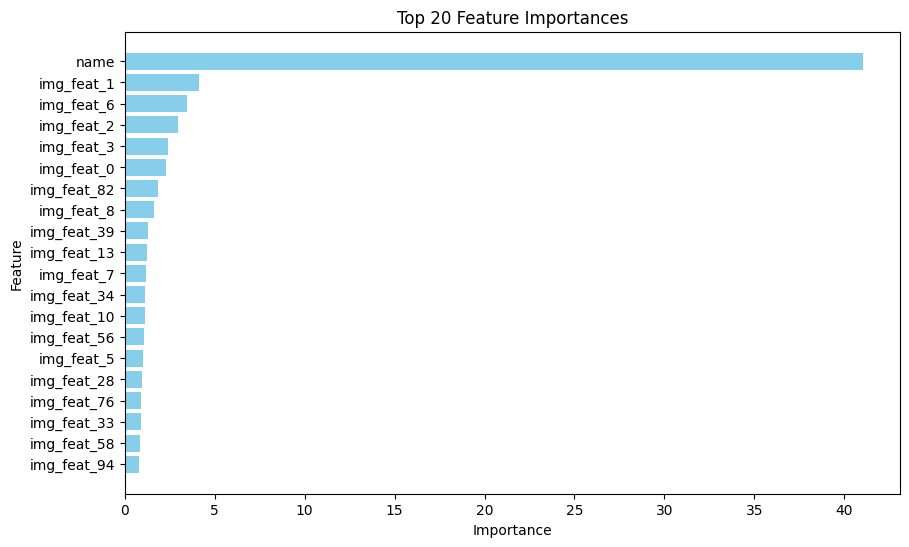

In [73]:
# Get feature importance
feature_importances = model.get_feature_importance(train_pool)
feature_names = final_train_df.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.show()